# Presentation of the code

Import package fipy: ('*' means import all fonctions)

In [1]:
from fipy import *

## Geometry and mesh

We first install the geometry of the situation.
The simulation is 1D (W=1., b=1.), relativ (L=1.).

### Space

In [2]:
L = 1. #length
W = 1. #width: characteristic length
b = 1. #gap

### Mesh

The mesh is decided with the length of one controle volume. For now, it is chosen as the smallest in the paper.

In [3]:
dx = 0.02 * W #width of controle volume
nx = L/dx #number of controle volume
mesh = Grid1D(dx=dx, nx=nx)

## Description of the fluids

### Parameters

Fluid 1 is the active fluid, less viscous. phi = 1.
Fluid 2 is the passive fluid, more viscous. phi = 0.
The two permeabilities are set to 1.
We introduce the parameter beta, easier to use.

In [4]:
viscosity2 = 1.
Mobility = 1. #ratio of the two viscosities
viscosity1 = viscosity2 * Mobility
permeability1 = permeability2 = 1.
beta1 = viscosity1 / permeability1
beta2 = viscosity2 / permeability2

### Variable of the fluids

The grid is colocated in FiPy.

In [5]:
pressure = CellVariable(mesh=mesh, name='pressure')
xVelocity = CellVariable(mesh=mesh, name='X Velocity')
velocity = FaceVariable(mesh=mesh, rank=1)

## Phase-field model

### Order parameter

The order parameter is phi. The hasOld option is important, because the phase-field equation is not linear so we need to iterate the solving of the equation at each time step. The commad hasOld permits to update the value of phi to use at the end of the iterations only.

In [6]:
phi = CellVariable(name=r'$\phi$', mesh=mesh, hasOld = 1)

### New values

The phase-field method means that the two fluids are not separated anymore: this means all the variable have to be defined on the whole domain. The particular variables are transformed by interpolation.

In [7]:
beta = CellVariable(mesh=mesh, name='beta', value = beta1 * phi + beta2 * (1-phi))

### Parameters of Phase field equation

The Cahn number is defined thanks to the values of the paper for the moment. Justification?
l is chosen as 1 because its impact is still to define.

In [8]:
Cahn_number = 0.001
epsilon = Cahn_number * W
M = Mobility * epsilon**2
l = 1.

### Phase-field equation

The equation chosen for the phase-field is base on Cahn-Hilliard model as described in the paper. (need of a better explanation here)
The first line is the creation of an interpolation of the value of phi on to the faces. FiPy would have it done automatically, but it is more accurate to do it by arithmeticFaceValue (We also get to choose what type of interpolation we use) (why arithmetic?? I think because more precise is not needed, but I need to review, not the priority though)

In [10]:
PHI = phi.arithmeticFaceValue #result more accurate by non-linear interpolation
coeff1 = Mobility * l * (3 * PHI**2 - 3 * PHI + 1/2)
eq = (TransientTerm() + ConvectionTerm(velocity) == DiffusionTerm(coeff=coeff1) - DiffusionTerm(coeff=(M, l)))

We have now all the parameters and the variables. We can now set the boundary conditions in time and space.

## Pressure and velocity

### Equations

We have here two coupled equations: in order to the variables to respect both at each time step, we need an iterative scheme with a correction of the pressure at each iteration. For this correction, we use the SIMPLE algorithm.
We introduce a new pressure variable that corresponds to the pressure once it has been corrected by the second equation, that will be used to begin again the iteration.

In [11]:
pressureCorrection = CellVariable(mesh=mesh)

We then introduce the equations: equation of motion, here Darcy's law and equation of continuity, permitting the correction of the pressure. (need to precise this point to explain better)

In [13]:
xVelocityEq = (ImplicitSourceTerm(coeff=beta) + pressure.grad[0]) #Darcy's law

ap = CellVariable(mesh=mesh, value=1.)
coeff = 1./ ap.arithmeticFaceValue * mesh._faceAreas * mesh._cellDistances
X = mesh.cellCenters[0]
pressureCorrectionEq = DiffusionTerm(coeff=coeff) - velocity.divergence 

### Rhie-Chow correction

FiPy uses a colocated grid, causing oscillations in the velocity field. It is necessary to apply a correction.

In [14]:
from fipy.variables.faceGradVariable import _FaceGradVariable
volume = CellVariable(mesh=mesh, value=mesh.cellVolumes, name='Volume')
contrvolume=volume.arithmeticFaceValue

## Boundary conditions

### Phase

Phi is set up as a crenau function in the beginning. Later, we sill set up other initial conditions so that we have a small random perturbation that permits the formation of fingers. Normally, here the fluids should advance without perturbation. 
(I think the first line is to define x as the first axis so we can define the boundary conditions.)

In [15]:
x = mesh.cellCenters[0]
def initialize(phi):
	phi.setValue(1.)
	phi.setValue(0., where=x > L/2)

initialize(phi)

### Velocity and pressure

We decide the rate of injection of the first fluid.
The boundary conditions are set on the velocity so that the rate is respected and the quantity of volume is conserved (incompressible fluids).

In [17]:
Q = 1. #rate of injection
U = Q / (b*W)
xVelocity.constrain(U, mesh.facesRight | mesh.facesLeft)
X = mesh.faceCenters
pressureCorrection.constrain(0., mesh.facesLeft)

## Viewers

********************************************************************************
         to build the TVTK classes (6.3). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



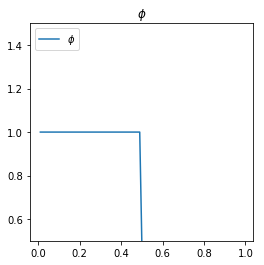

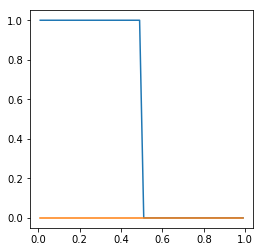

In [18]:
viewer = Viewer(vars = (phi,), datamin=0.5, datamax=1.5)
viewer2 = Viewer(vars = (phi, pressure, velocity))

## Initialization

We need to initialize the phase-field to separate the effcet of forming from the effect of moving it. For this, we need to have the initial fields of the pressure and the velocity.

### Pressure and velocity fields

We use the SIMPLE algorithm that we will use at each iteration.
The relaxation are kept the same as in the example. (need to review the exact utility)

In [19]:
pressureRelaxation = 0.8
velocityRelaxation = 0.5

sweeps = 50
for sweep in range(sweeps):
    ##Solve the Stokes equations to get starred values
    xVelocityEq.cacheMatrix()
    xres = xVelocityEq.sweep(var=xVelocity, underRelaxation=velocityRelaxation)
    xmat = xVelocityEq.matrix
    ##update the ap coefficient from the matrix diagonal
    ap[:] = xmat.takeDiagonal()
    #print(ap)
    #
    ##update the face velocities based on starred values with the Rhi-Chow correction
    #cell pressure gradient
    presgrad = pressure.grad
    #face pressure gradient
    facepresgrad = _FaceGradVariable(pressure)
    #
    velocity[0] = xVelocity.arithmeticFaceValue + contrvolume / ap.arithmeticFaceValue * (presgrad[0].arithmeticFaceValue-facepresgrad[0])
    #velocity[..., mesh.exteriorFaces.value]=0.
    velocity[0].constrain(U, mesh.facesRight | mesh.facesLeft)
    #
    ##solve the pressure correction equation
    pressureCorrectionEq.cacheRHSvector()
    ## left bottom point must remain at pressure 0, so no correction
    pres = pressureCorrectionEq.sweep(var=pressureCorrection)
    rhs = pressureCorrectionEq.RHSvector
    #
    ## update the pressure using the corrected value
    pressure.setValue(pressure + pressureRelaxation * pressureCorrection)
    ## update the velocity using the corrected pressure
    xVelocity.setValue(xVelocity - pressureCorrection.grad[0] / ap * mesh.cellVolumes)

### Phase field

The time step here is only used to resolve the equation. But the iteration here are not time steps, but iteartion to getr a more accurate solution: by using the new value obtained at the solving of the equation, we are closer to the solution, so by solving it again with this value, we get a more little residual, a more accurate solution. (we have a descritez solution, so the closer the values are when solving, the solution gets more accurate : by convergence.) (need to get this clearer)

In [20]:
phi.updateOld()
#Phase
for i in range(500):
    eq.solve(var=phi, dt = 1e-6)
    phi.updateOld()

viewer.plot()

## Dynamics

do functions, so that only the last algorithm is needed.

The reisduals need to be decided.

In [ ]:
timeStep = 1e-6

for i in range(500):
    for j in range(10):
    	phi.updateOld()
    	res = 1e+10
    	while res > 1e-5:
    		res = eq.sweep(var=phi, dt=timeStep)
    for sweep in range(sweeps):
        ##Solve the Stokes equations to get starred values
        xVelocityEq.cacheMatrix()
        xres = xVelocityEq.sweep(var=xVelocity, underRelaxation=velocityRelaxation)
        xmat = xVelocityEq.matrix
        ##update the ap coefficient from the matrix diagonal
        ap[:] = xmat.takeDiagonal()
        #print(ap)
        #
        ##update the face velocities based on starred values with the Rhi-Chow correction
        #cell pressure gradient
        presgrad = pressure.grad
        #face pressure gradient
        facepresgrad = _FaceGradVariable(pressure)
        #
        velocity[0] = xVelocity.arithmeticFaceValue + contrvolume / ap.arithmeticFaceValue * (presgrad[0].arithmeticFaceValue-facepresgrad[0])
        #velocity[..., mesh.exteriorFaces.value]=0.
        velocity[0].constrain(U, mesh.facesRight | mesh.facesLeft)
        #
        ##solve the pressure correction equation
        pressureCorrectionEq.cacheRHSvector()
        ## left bottom point must remain at pressure 0, so no correction
        pres = pressureCorrectionEq.sweep(var=pressureCorrection)
        rhs = pressureCorrectionEq.RHSvector
        #
        ## update the pressure using the corrected value
        pressure.setValue(pressure + pressureRelaxation * pressureCorrection)
        ## update the velocity using the corrected pressure
        xVelocity.setValue(xVelocity - pressureCorrection.grad[0] / ap * mesh.cellVolumes)


viewer.plot()
